In [3]:
!pip install holidays
!pip install xgboost

In [4]:
import pandas as pd
import numpy as np
import holidays
from datetime import timedelta
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import classification_report
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings('ignore')

In [5]:
# MORE PREPROCESSING

purchase_df =  pd.read_csv('../DATA/process-purchases.csv')

purchase_df['order_date'] = pd.to_datetime(purchase_df['Order Date'])

purchase_df['month'] = purchase_df['order_date'].dt.month
purchase_df['year'] = purchase_df['order_date'].dt.year
purchase_df['season'] = purchase_df['month'].map({
    12:'Winter',1:'Winter',2:'Winter',
    3:'Spring',4:'Spring',5:'Spring',
    6:'Summer',7:'Summer',8:'Summer',
    9:'Fall',10:'Fall',11:'Fall'
})

purchase_df['is_weekend'] = purchase_df['order_date'].dt.dayofweek.isin([5,6]).astype(int)

us_holidays = holidays.UnitedStates()

purchase_df['is_holiday'] = purchase_df['order_date'].isin(us_holidays)


def mark_pre_holiday_dates(dates, holiday_dict, window=7):
  """Return list marking whether each date is within N days before a holiday."""
  holiday_dates = pd.to_datetime(list(holiday_dict.keys()))
  return [
      any((h - timedelta(days=window) <= d < h) for h in holiday_dates)
      for d in pd.to_datetime(dates)
  ]


purchase_df['is_preholiday'] = (
    mark_pre_holiday_dates(purchase_df['order_date'], us_holidays, window=7)
)
purchase_df['is_preholiday'] = purchase_df['is_preholiday'].astype(int)





In [6]:
year_min = purchase_df['order_date'].dt.year.min()
year_max = purchase_df['order_date'].dt.year.max()

print(f"Data covers from {year_min} to {year_max}")

Data covers from 2018 to 2024


In [7]:
# --- RUN THE MODEL FOR ALL CATEGORIES ---

monthly = (
    purchase_df.groupby(['Category', pd.Grouper(key='order_date', freq='M')])
               .size()
               .reset_index(name='num_orders')
)

# exogenous regressor: pre-holiday flag by month
exog_monthly = (
    purchase_df.groupby(pd.Grouper(key='order_date', freq='M'))['is_preholiday']
               .max()
               .to_frame()
)

forecast_results = []

# iterate over every category
for cat in monthly['Category'].unique():
    sub = monthly[monthly['Category'] == cat].set_index('order_date')['num_orders']
    sub = sub.asfreq('M').fillna(0)

    exog = exog_monthly.reindex(sub.index).fillna(0)

    n_months = len(sub)
    if n_months < 36:   # skip categories with too little history
        continue

    test_size = 12
    val_size = 24
    train_end = -(val_size + test_size)
    val_end   = -test_size

    train = sub.iloc[:train_end]
    val   = sub.iloc[train_end:val_end]
    test  = sub.iloc[val_end:]

    train_exog = exog.iloc[:train_end]
    val_exog   = exog.iloc[train_end:val_end]
    test_exog  = exog.iloc[val_end:]


    try:
        model = SARIMAX(
            train,
            order=(2, 0, 2),
            seasonal_order=(1, 1, 0, 12),
            exog=train_exog
        )
        fit = model.fit(disp=False)

        forecast_val  = fit.forecast(steps=len(val), exog=val_exog)
        forecast_test = fit.forecast(steps=len(test), exog=test_exog)

        # store forecasted test period for this category
        temp = pd.DataFrame({
            "Category": cat,
            "month": test.index,
            "forecast_sales": forecast_test.values
        })
        forecast_results.append(temp)

    except Exception as e:
        print(f"Skipping {cat} due to error: {e}")
        continue

# combine all category forecasts into one DataFrame
forecast_df = pd.concat(forecast_results, ignore_index=True)
forecast_df.to_csv("forecast-results.csv", index=False)

Skipping ABIS_BEAUTY due to error: zero-size array to reduction operation maximum which has no identity
Skipping ASTRINGENT_SUBSTANCE due to error: LU decomposition error.
Skipping BOX_SPRING due to error: all the input arrays must have same number of dimensions, but the array at index 0 has 1 dimension(s) and the array at index 1 has 2 dimension(s)
Skipping DIGITAL_VIDEO_RECORDER due to error: all the input arrays must have same number of dimensions, but the array at index 0 has 1 dimension(s) and the array at index 1 has 2 dimension(s)
Skipping ELECTRONIC_CIGARETTE due to error: zero-size array to reduction operation maximum which has no identity
Skipping LAUNDRY_APPLIANCE due to error: LU decomposition error.
Skipping ORCA_SHIRT due to error: LU decomposition error.
Skipping RANGE due to error: all the input arrays must have same number of dimensions, but the array at index 0 has 1 dimension(s) and the array at index 1 has 2 dimension(s)
Skipping SOAP_DISH due to error: LU decomposi

In [8]:
import itertools

p = d = q = range(0, 3)        # non-seasonal
P = D = Q = range(0, 2)        # seasonal
m = 12                         # monthly seasonality

params = list(itertools.product(p, d, q, P, D, Q))
print("Total combinations:", len(params))

from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

results = []

for (p_, d_, q_, P_, D_, Q_) in params:
    try:
        model = SARIMAX(
            train,
            order=(p_, d_, q_),
            seasonal_order=(P_, D_, Q_, 12),
            exog=train_exog
        ).fit(disp=False)

        forecast_val = model.forecast(steps=len(val), exog=val_exog)
        rmse = np.sqrt(mean_squared_error(val, forecast_val))
        results.append({
            "order": (p_, d_, q_),
            "seasonal_order": (P_, D_, Q_, 12),
            "RMSE": rmse,
            "AIC": model.aic
        })
    except:
        continue

results_df = pd.DataFrame(results).sort_values("RMSE")
print(results_df.head(10))

best = results_df.iloc[0]
print("Best model:", best["order"], best["seasonal_order"], "RMSE:", best["RMSE"])

fit_final = SARIMAX(
    pd.concat([train, val]),
    order=best["order"],
    seasonal_order=best["seasonal_order"],
    exog=pd.concat([train_exog, val_exog])
).fit(disp=False)

forecast_test = fit_final.forecast(steps=len(test), exog=test_exog)

Total combinations: 216
         order seasonal_order      RMSE        AIC
36   (0, 1, 1)  (1, 0, 0, 12)  1.821503  94.241094
33   (0, 1, 1)  (0, 0, 1, 12)  1.822222  94.247166
32   (0, 1, 1)  (0, 0, 0, 12)  1.825742  92.265683
108  (1, 1, 1)  (1, 0, 0, 12)  1.828287  96.028428
105  (1, 1, 1)  (0, 0, 1, 12)  1.828626  96.028904
104  (1, 1, 1)  (0, 0, 0, 12)  1.829488  94.030071
40   (0, 1, 2)  (0, 0, 0, 12)  1.831871  93.911988
41   (0, 1, 2)  (0, 0, 1, 12)  1.832110  95.911899
44   (0, 1, 2)  (1, 0, 0, 12)  1.832205  95.911866
185  (2, 1, 2)  (0, 0, 1, 12)  1.834285  98.744100
Best model: (0, 1, 1) (1, 0, 0, 12) RMSE: 1.8215026318557896


In [9]:
from sklearn.metrics import mean_absolute_error
import numpy as np

mae = mean_absolute_error(val, forecast_val)
mape = np.mean(np.abs((val - forecast_val) / np.maximum(val, 1))) * 100

print(f"MAE: {mae:.2f}, MAPE: {mape:.2f}%")

MAE: 9.12, MAPE: 467.26%


In [10]:
# === EXPORT FORECAST RESULTS FOR PART 2 ===

# Rebuild a DataFrame of forecasted vs. actuals
forecast_df = pd.DataFrame({
    "date": test.index,
    "actual_sales": test.values,
    "forecast_sales": forecast_test.values,
    "Category": cat
})

# Optionally include validation data too
val_df = pd.DataFrame({
    "date": val.index,
    "actual_sales": val.values,
    "forecast_sales": forecast_val.values,
    "Category": cat
})

# Combine validation + test for a richer forecast history
forecast_all = pd.concat([val_df, forecast_df]).reset_index(drop=True)

# Save for Part 2 use
forecast_all.to_csv("../DATA/forecast-results.csv", index=False)
print("✅ Forecast results saved to 'forecast_results.csv'")


✅ Forecast results saved to 'forecast_results.csv'


### Part 2 - Predicting the Next Category

In [12]:
import pandas as pd

forecast_df = pd.read_csv("../DATA/forecast-results.csv")
forecast_df["date"] = pd.to_datetime(forecast_df["date"])
forecast_df = forecast_df.rename(columns={"date": "month"})
print("Forecast sample:")
print(forecast_df.head(), "\n")

Forecast sample:
       month  actual_sales  forecast_sales         Category
0 2020-03-31           2.0       -0.488709  ZIPPER_FASTENER
1 2020-04-30           1.0        1.739630  ZIPPER_FASTENER
2 2020-05-31           1.0        0.033700  ZIPPER_FASTENER
3 2020-06-30           3.0        0.469983  ZIPPER_FASTENER
4 2020-07-31           2.0       -2.173786  ZIPPER_FASTENER 



In [13]:
purchases = pd.read_csv("../DATA/process-purchases.csv")
purchases["order_date"] = pd.to_datetime(purchases["Order Date"])
purchases["month"] = purchases["order_date"].dt.to_period("M").dt.to_timestamp()
top_categories = purchases["Category"].value_counts().nlargest(20).index
purchases = purchases[purchases["Category"].isin(top_categories)]

print("✅ Limiting data to top 20 categories:")
print(top_categories.tolist())
print("Remaining rows:", len(purchases))


✅ Limiting data to top 20 categories:
['ABIS_BOOK', 'PET_FOOD', 'GIFT_CARD', 'SHIRT', 'NUTRITIONAL_SUPPLEMENT', 'ELECTRONIC_CABLE', 'HEALTH_PERSONAL_CARE', 'MEDICATION', 'PANTS', 'CELLULAR_PHONE_CASE', 'SKIN_MOISTURIZER', 'SHOES', 'FOOD', 'GROCERY', 'VEGETABLE', 'TOYS_AND_GAMES', 'TOY_FIGURE', 'SKIN_CLEANING_AGENT', 'HEADPHONES', 'VITAMIN']
Remaining rows: 410129


In [14]:
merged = purchases.merge(forecast_df, on="month", how="left")

print("Merged shape:", merged.shape)
print("Merged columns:", merged.columns.tolist(), "\n")

Merged shape: (410129, 12)
Merged columns: ['Order Date', 'Category_x', 'Survey ResponseID', 'Q-demos-gender', 'Q-demos-age', 'Q-demos-income', 'Q-demos-race', 'order_date', 'month', 'actual_sales', 'forecast_sales', 'Category_y'] 



In [15]:
user_summary = (
    merged.groupby("Survey ResponseID")
          .agg({
              "forecast_sales": "mean",     # avg forecast for months they purchased
              "Q-demos-gender": "first",
              "Q-demos-age": "first",
              "Q-demos-income": "first",
              "Q-demos-race": "first"
          })
          .reset_index()
)
user_summary = user_summary.rename(columns={"forecast_sales": "avg_forecasted_sales"})

print("User-level summary sample:")
print(user_summary.head(), "\n")

User-level summary sample:
   Survey ResponseID  avg_forecasted_sales Q-demos-gender    Q-demos-age  \
0  R_01vNIayewjIIKMF                   NaN           Male  35 - 44 years   
1  R_037XK72IZBJyF69                   NaN         Female  55 - 64 years   
2  R_038ZU6kfQ5f89fH                   NaN           Male  25 - 34 years   
3  R_03aEbghUILs9NxD                   NaN           Male  35 - 44 years   
4  R_06RZP9pS7kONINr                   NaN         Female   65 and older   

      Q-demos-income               Q-demos-race  
0  $25,000 - $49,999  Black or African American  
1  $25,000 - $49,999         White or Caucasian  
2  $25,000 - $49,999         White or Caucasian  
3  $50,000 - $74,999         White or Caucasian  
4  $75,000 - $99,999         White or Caucasian   



In [16]:
feature_cols = [
    "Q-demos-gender",
    "Q-demos-age",
    "Q-demos-income",
    "Q-demos-race",
    "forecast_sales"
]

X = merged[feature_cols].copy()
y_cat = merged["Category"] if "Category" in merged.columns else merged["Category_x"]

In [17]:
X = pd.get_dummies(X, drop_first=True, dtype=float)

# Replace missing values with 0
X = X.fillna(0)

print("Feature matrix shape:", X.shape)
print("Target distribution:")
print(y_cat.value_counts().head(), "\n")

Feature matrix shape: (410129, 39)
Target distribution:
Category_x
ABIS_BOOK                 87619
PET_FOOD                  38256
GIFT_CARD                 27734
SHIRT                     27267
NUTRITIONAL_SUPPLEMENT    26913
Name: count, dtype: int64 



In [18]:
counts = y_cat.value_counts()
valid_classes = counts[counts > 1].index
mask = y_cat.isin(valid_classes)
X = X[mask]
y_cat = y_cat[mask]

In [19]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_cat_encoded = le.fit_transform(y_cat)

In [20]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_cat_encoded, stratify=y_cat_encoded, test_size=0.2, random_state=42
)


In [21]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

model = XGBClassifier(
    use_label_encoder=False,
    eval_metric="mlogloss",
    n_estimators=300,
    learning_rate=0.1,
    max_depth=6
)
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, ...)

In [22]:
y_pred = model.predict(X_test)
print("Classification Report:\n")
print(classification_report(y_test, y_pred, zero_division=0))

# Decode predictions back to human-readable categories
y_pred_labels = le.inverse_transform(y_pred)

Classification Report:

              precision    recall  f1-score   support

           0       0.23      0.93      0.37     17524
           1       0.23      0.00      0.01      3074
           2       0.23      0.01      0.02      3654
           3       0.25      0.06      0.10      2491
           4       0.33      0.19      0.24      5547
           5       0.25      0.01      0.02      2422
           6       0.18      0.00      0.01      2279
           7       0.24      0.01      0.01      3325
           8       0.15      0.01      0.02      3237
           9       0.24      0.07      0.11      5383
          10       0.07      0.00      0.00      3189
          11       0.26      0.14      0.18      7651
          12       0.16      0.01      0.02      5453
          13       0.15      0.00      0.01      2552
          14       0.22      0.01      0.01      2283
          15       0.14      0.01      0.01      2733
          16       0.21      0.00      0.00      2325
   

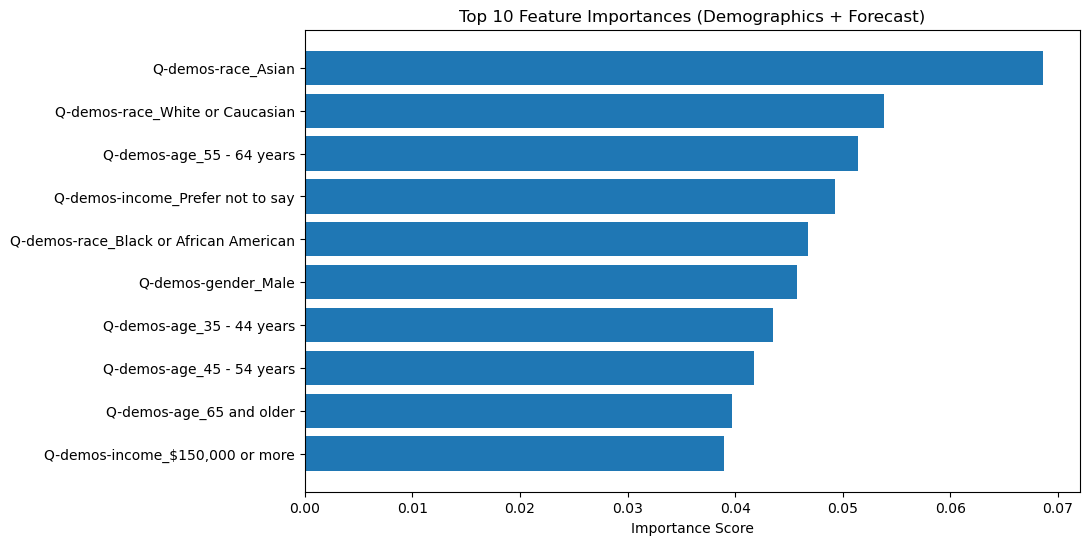

In [23]:
import matplotlib.pyplot as plt

importances = model.feature_importances_
indices = importances.argsort()[-10:][::-1]
top_features = X.columns[indices]

plt.figure(figsize=(10, 6))
plt.barh(top_features, importances[indices])
plt.xlabel("Importance Score")
plt.title("Top 10 Feature Importances (Demographics + Forecast)")
plt.gca().invert_yaxis()
plt.show()